**Inflation Forecasting: Modelling Notebook**

This notebook was made to forecast inflation rate in Indonesia based on 2019-2024 data.

Version: January 2025
___

- Developed by [Hamam Wulan Ayu](https://www.linkedin.com/in/hwulanayu/) and [Irfan Chairur Rachman](https://www.linkedin.com/in/irfanchairurrachman/)

# Inflation Forecasting 

This notebook explores several machine learning (ML) methods to improve inflation forecasting in Indonesia. The goal is to forecast general price inflation, based on various macroeconomic factors that affect inflation rate <sup>[[1]](#reference)</sup>. The data was collected for 2019-2024.

This notebook uses Random Forest Regressor, Prophet time series, and Vanilla Neural Network methods to forecast inflation with the best performance is Vanilla Neural Network with 0.821 RMSE and 26.07% MAPE.

This project divided by two notebook:
1. `1_Wrangling.ipynb`: Consist of loading, exploring, wrangling and cleaning data for machine learning input.
2. **`2_Modelling.ipynb`: Consist of preprocessing, modelling and evaluating processes.**

# Preprocessing & Modelling

The preprocessing use various technique to cleansing, evaluation and improve model performance. The preprocessing consist of:
- Create new columns consist of lagging data
- Cross-validation
- Imputation missing value
- Standardization

The modelling process using these methods:
- Random Forest
- Prophet Time Series
- Vanilla Neural Network


## Load Library and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

from prophet import Prophet

import tensorflow as tf
import tensorflow.keras as keras
import random

# suppress warning
import warnings
warnings.filterwarnings("ignore")
# not scientific format
pd.set_option("display.float_format", '{:,.2f}'.format)

c:\Users\USER\miniconda3\envs\dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Clean Data

The clean data are resulted from wrangling and cleaning processes in `1_Wrangling.ipynb`. The data include external factors, which are:
- [x] IHK (*Indeks Harga Konsumen*)
- [x] BI rate (*tingkat suku bunga*)
- [x] Money supply (*jumlah uang beredar*)
- [x] Rupiah-to-dollar exhange rate
- [x] IHSG
- [x] Credit value

In [2]:
clean_df = pd.read_csv("data/clean_df.csv", parse_dates=['Bulan'])
clean_df.head()

,Bulan,Kurs RP USD,IHSG,Uang Beredar,UMUM,IHK,Suku Bunga,Kredit
0,2019-01-01,"14,460.00","6,532.97","5,644,985.00",2.48,132.37,6.00,11.72
1,2019-02-01,"13,931.60","6,443.35","5,670,778.00",2.67,132.26,6.00,11.68
2,2019-03-01,"14,195.50","6,468.75","5,747,247.00",2.37,132.60,6.00,11.64
3,2019-04-01,"14,233.00","6,455.35","5,746,732.00",2.61,133.21,6.00,11.62
4,2019-05-01,"14,286.00","6,209.12","5,860,509.00",3.12,133.77,6.00,11.57


In [3]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 69
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Bulan         70 non-null     datetime64[ns]
 1   Kurs RP USD   70 non-null     float64       
 2   IHSG          70 non-null     float64       
 3   Uang Beredar  70 non-null     float64       
 4   UMUM          70 non-null     float64       
 5   IHK           70 non-null     float64       
 6   Suku Bunga    70 non-null     float64       
 7   Kredit        70 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 4.9+ KB


In [4]:
clean_df.describe()

,Bulan,Kurs RP USD,IHSG,Uang Beredar,UMUM,IHK,Suku Bunga,Kredit
count,70,70.00,70.00,70.00,70.00,70.00,70.00,70.00
mean,2021-11-15 11:39:25.714285824,"14,791.90","6,457.98","7,446,619.04",3.10,109.64,4.85,10.81
min,2019-01-01 00:00:00,"13,762.30","4,538.93","5,644,985.00",-0.28,98.18,3.50,10.28
25%,2020-06-08 12:00:00,"14,266.55","6,026.38","6,493,076.38",1.92,103.45,3.56,10.41
50%,2021-11-16 00:00:00,"14,600.65","6,586.41","7,610,054.54",2.63,105.70,5.00,10.59
75%,2023-04-23 12:00:00,"15,249.60","7,018.91","8,351,635.34",3.57,107.04,6.00,11.19
max,2024-10-01 00:00:00,"16,395.50","7,670.73","9,081,690.58",8.55,135.46,6.25,11.72
std,NaN,672.89,740.30,"1,078,607.50",1.86,11.29,1.07,0.47


# Preprocessing

## Create Lagged Data

The purpose of creating new columns containing lag data in inflation prediction modelling using regression is to capture historical patterns and improve the model's accuracy by incorporating past values as predictors.

We will use 3 months lag, which captures 3 previous months of value. All columns except `Bulan` will be used to create the lagged columns.

In [5]:
columns_to_lag = clean_df.columns[1:].tolist()

n_lags = 3

columns_to_lag

['Kurs RP USD', 'IHSG', 'Uang Beredar', 'UMUM', 'IHK', 'Suku Bunga', 'Kredit']

In [6]:
lags = []
for lag in range(1, n_lags + 1):
    lagged_cols = clean_df[columns_to_lag].shift(lag)
    lagged_cols.columns = [f"{col}_lag{lag}" for col in columns_to_lag]
    lags.append(lagged_cols)

In [7]:
lags

[    Kurs RP USD_lag1  IHSG_lag1  Uang Beredar_lag1  UMUM_lag1  IHK_lag1  \
 0                NaN        NaN                NaN        NaN       NaN   
 1          14,460.00   6,532.97       5,644,985.00       2.48    132.37   
 2          13,931.60   6,443.35       5,670,778.00       2.67    132.26   
 3          14,195.50   6,468.75       5,747,247.00       2.37    132.60   
 4          14,233.00   6,455.35       5,746,732.00       2.61    133.21   
 ..               ...        ...                ...        ...       ...   
 65         16,083.94   7,118.84       9,022,913.43       3.52    107.02   
 66         16,329.39   6,861.85       9,065,748.76       3.33    106.88   
 67         16,320.00   7,255.76       8,983,383.35       2.14    106.00   
 68         15,409.00   7,670.73       8,975,511.86       2.50    105.99   
 69         15,138.00   7,527.93       9,047,998.70       1.95    105.81   
 
     Suku Bunga_lag1  Kredit_lag1  
 0               NaN          NaN  
 1            

In [8]:
df_indikator = clean_df.copy()
df_indikator['tahun'] = clean_df['Bulan'].dt.year.astype(int)
df_indikator['bulan'] = clean_df['Bulan'].dt.month.astype(int)
df_indikator['hari_dalam_minggu'] = clean_df['Bulan'].dt.weekday.astype(int)
df_indikator = df_indikator.drop(columns='Bulan')

df_indikator.head()

,Kurs RP USD,IHSG,Uang Beredar,UMUM,IHK,Suku Bunga,Kredit,tahun,bulan,hari_dalam_minggu
0,"14,460.00","6,532.97","5,644,985.00",2.48,132.37,6.00,11.72,2019,1,1
1,"13,931.60","6,443.35","5,670,778.00",2.67,132.26,6.00,11.68,2019,2,4
2,"14,195.50","6,468.75","5,747,247.00",2.37,132.60,6.00,11.64,2019,3,4
3,"14,233.00","6,455.35","5,746,732.00",2.61,133.21,6.00,11.62,2019,4,0
4,"14,286.00","6,209.12","5,860,509.00",3.12,133.77,6.00,11.57,2019,5,2


In [9]:
lagged_df = pd.concat(lags, axis=1)

df_predictor = pd.concat([df_indikator, lagged_df], axis=1)

df_predictor.head(10).T

,0,1,2,3,4,5,6,7,8,9
Kurs RP USD,"14,460.00","13,931.60","14,195.50","14,233.00","14,286.00","14,399.00","14,121.00","14,165.00","14,264.00","14,221.90"
IHSG,"6,532.97","6,443.35","6,468.75","6,455.35","6,209.12","6,358.63","6,390.50","6,328.47","6,169.10","6,228.32"
Uang Beredar,"5,644,985.00","5,670,778.00","5,747,247.00","5,746,732.00","5,860,509.00","5,908,509.00","5,941,133.00","5,934,562.00","6,134,178.00","6,026,908.00"
UMUM,2.48,2.67,2.37,2.61,3.12,3.16,4.07,3.37,3.23,2.03
IHK,132.37,132.26,132.60,133.21,133.77,134.10,134.17,134.27,134.18,134.42
Suku Bunga,6.00,6.00,6.00,6.00,6.00,6.00,5.75,5.50,5.25,5.00
Kredit,11.72,11.68,11.64,11.62,11.57,11.57,11.55,11.55,11.53,11.51
tahun,"2,019.00","2,019.00","2,019.00","2,019.00","2,019.00","2,019.00","2,019.00","2,019.00","2,019.00","2,019.00"
bulan,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00
hari_dalam_minggu,1.00,4.00,4.00,0.00,2.00,5.00,0.00,3.00,6.00,1.00


The dataframe resulted with new columns that contain lag of the value. Some first rows contain NaN because they do not have previous value to create the lag.

This NaN value will be handled in the following step.

## Cross Validation

The assess the model, we need to split the data to train and test dataset. The train dataset are for model training, whereas the test dataset are for model evaluation.

First, we need to split the dataset into the predictor (X) and the target (y).

In [10]:
X = df_predictor.drop(columns='UMUM')
y = df_predictor['UMUM']

In [11]:
X.head()

,Kurs RP USD,IHSG,Uang Beredar,IHK,Suku Bunga,Kredit,tahun,bulan,hari_dalam_minggu,Kurs RP USD_lag1,...,IHK_lag2,Suku Bunga_lag2,Kredit_lag2,Kurs RP USD_lag3,IHSG_lag3,Uang Beredar_lag3,UMUM_lag3,IHK_lag3,Suku Bunga_lag3,Kredit_lag3
0,"14,460.00","6,532.97","5,644,985.00",132.37,6.00,11.72,2019,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"13,931.60","6,443.35","5,670,778.00",132.26,6.00,11.68,2019,2,4,"14,460.00",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"14,195.50","6,468.75","5,747,247.00",132.60,6.00,11.64,2019,3,4,"13,931.60",...,132.37,6.00,11.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"14,233.00","6,455.35","5,746,732.00",133.21,6.00,11.62,2019,4,0,"14,195.50",...,132.26,6.00,11.68,"14,460.00","6,532.97","5,644,985.00",2.48,132.37,6.00,11.72
4,"14,286.00","6,209.12","5,860,509.00",133.77,6.00,11.57,2019,5,2,"14,233.00",...,132.60,6.00,11.64,"13,931.60","6,443.35","5,670,778.00",2.67,132.26,6.00,11.68


In [12]:
y.head()

0   2.48
1   2.67
2   2.37
3   2.61
4   3.12
Name: UMUM, dtype: float64

The proportion of train dataset is 80% and 20% for test dataset.

In [13]:
# Split data menjadi train dan test set (80-20 split)
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [14]:
X_test.head().T

,56,57,58,59,60
Kurs RP USD,"15,231.00","15,487.20","15,748.70","15,549.30","15,383.10"
IHSG,"6,939.89","6,752.21","7,080.74","7,272.80","7,207.94"
Uang Beredar,"8,441,236.44","8,506,544.06","8,574,917.10","8,826,531.00","8,721,949.69"
IHK,103.79,104.28,104.86,105.05,105.92
Suku Bunga,5.75,6.00,6.00,6.00,6.00
Kredit,10.47,10.45,10.43,10.40,10.41
tahun,"2,023.00","2,023.00","2,023.00","2,023.00","2,024.00"
bulan,9.00,10.00,11.00,12.00,1.00
hari_dalam_minggu,4.00,6.00,2.00,4.00,0.00
Kurs RP USD_lag1,"15,104.00","15,231.00","15,487.20","15,748.70","15,549.30"


In [15]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 56 to 69
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Kurs RP USD        14 non-null     float64
 1   IHSG               14 non-null     float64
 2   Uang Beredar       14 non-null     float64
 3   IHK                14 non-null     float64
 4   Suku Bunga         14 non-null     float64
 5   Kredit             14 non-null     float64
 6   tahun              14 non-null     int32  
 7   bulan              14 non-null     int32  
 8   hari_dalam_minggu  14 non-null     int32  
 9   Kurs RP USD_lag1   14 non-null     float64
 10  IHSG_lag1          14 non-null     float64
 11  Uang Beredar_lag1  14 non-null     float64
 12  UMUM_lag1          14 non-null     float64
 13  IHK_lag1           14 non-null     float64
 14  Suku Bunga_lag1    14 non-null     float64
 15  Kredit_lag1        14 non-null     float64
 16  Kurs RP USD_lag2   14 non-null  

## Imputation Missing Value

The lagged dataframe resulted NaN value for rows that do not have previous value. This NaN will resulted bias and error when fitting the model. Therefore, the NaN will be filled with mean value of the column. In this case, the mean value resulted best model compared to other central tendency metrics like median and mode.

In [16]:
df_predictor.isnull().sum()

Kurs RP USD          0
IHSG                 0
Uang Beredar         0
UMUM                 0
IHK                  0
Suku Bunga           0
Kredit               0
tahun                0
bulan                0
hari_dalam_minggu    0
Kurs RP USD_lag1     1
IHSG_lag1            1
Uang Beredar_lag1    1
UMUM_lag1            1
IHK_lag1             1
Suku Bunga_lag1      1
Kredit_lag1          1
Kurs RP USD_lag2     2
IHSG_lag2            2
Uang Beredar_lag2    2
UMUM_lag2            2
IHK_lag2             2
Suku Bunga_lag2      2
Kredit_lag2          2
Kurs RP USD_lag3     3
IHSG_lag3            3
Uang Beredar_lag3    3
UMUM_lag3            3
IHK_lag3             3
Suku Bunga_lag3      3
Kredit_lag3          3
dtype: int64

In [17]:
# # Menampilkan kolom yang memiliki missing values
missing_columns = df_predictor.columns[df_predictor.isnull().any()]
print(df_predictor[missing_columns].isnull().sum())

Kurs RP USD_lag1     1
IHSG_lag1            1
Uang Beredar_lag1    1
UMUM_lag1            1
IHK_lag1             1
Suku Bunga_lag1      1
Kredit_lag1          1
Kurs RP USD_lag2     2
IHSG_lag2            2
Uang Beredar_lag2    2
UMUM_lag2            2
IHK_lag2             2
Suku Bunga_lag2      2
Kredit_lag2          2
Kurs RP USD_lag3     3
IHSG_lag3            3
Uang Beredar_lag3    3
UMUM_lag3            3
IHK_lag3             3
Suku Bunga_lag3      3
Kredit_lag3          3
dtype: int64


In [18]:
from sklearn.impute import SimpleImputer
# Inisialisasi imputer
imputer = SimpleImputer(strategy='mean')  # Atau bisa 'median', 'most_frequent', dll

# Fitting imputer pada data pelatihan
X_train_imputed = imputer.fit_transform(X_train)

# Transformasi data uji dengan imputer yang telah dilatih
X_test_imputed = imputer.transform(X_test)

## Standardization

The objective os standardization is to unify the feature scales so that machine learning algorithms can more effectively identify patterns.

To perform standardization, scaler object need to calculate mean and std from train dataset, those values will be used to transform and scaling the values in dataset.

In [19]:
from sklearn.preprocessing import StandardScaler

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Standarisasi data
value_train_scaled = scaler.fit_transform(X_train_imputed) # Fit dan transform pada X_train
value_test_scaled = scaler.transform(X_test_imputed) 

In [20]:
x_columns = X_train.columns
x_columns

Index(['Kurs RP USD', 'IHSG', 'Uang Beredar', 'IHK', 'Suku Bunga', 'Kredit',
       'tahun', 'bulan', 'hari_dalam_minggu', 'Kurs RP USD_lag1', 'IHSG_lag1',
       'Uang Beredar_lag1', 'UMUM_lag1', 'IHK_lag1', 'Suku Bunga_lag1',
       'Kredit_lag1', 'Kurs RP USD_lag2', 'IHSG_lag2', 'Uang Beredar_lag2',
       'UMUM_lag2', 'IHK_lag2', 'Suku Bunga_lag2', 'Kredit_lag2',
       'Kurs RP USD_lag3', 'IHSG_lag3', 'Uang Beredar_lag3', 'UMUM_lag3',
       'IHK_lag3', 'Suku Bunga_lag3', 'Kredit_lag3'],
      dtype='object')

In [21]:
X_train_scaled = X_train.copy()
X_train_scaled[x_columns] = value_train_scaled

X_test_scaled = X_test.copy()
X_test_scaled[x_columns] = value_test_scaled

X_train_scaled.head()

,Kurs RP USD,IHSG,Uang Beredar,IHK,Suku Bunga,Kredit,tahun,bulan,hari_dalam_minggu,Kurs RP USD_lag1,...,IHK_lag2,Suku Bunga_lag2,Kredit_lag2,Kurs RP USD_lag3,IHSG_lag3,Uang Beredar_lag3,UMUM_lag3,IHK_lag3,Suku Bunga_lag3,Kredit_lag3
0,-0.20,0.38,-1.61,1.76,1.49,1.74,-1.37,-1.54,-0.96,0.00,...,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00
1,-1.24,0.25,-1.58,1.76,1.49,1.65,-1.37,-1.25,0.56,-0.18,...,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00
2,-0.72,0.29,-1.50,1.78,1.49,1.57,-1.37,-0.95,0.56,-1.23,...,1.75,1.58,1.73,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00
3,-0.65,0.27,-1.50,1.83,1.49,1.52,-1.37,-0.65,-1.46,-0.71,...,1.74,1.58,1.64,-0.15,0.44,-1.62,-0.38,1.75,1.63,1.73
4,-0.54,-0.09,-1.37,1.88,1.49,1.41,-1.37,-0.36,-0.45,-0.63,...,1.77,1.58,1.56,-1.22,0.30,-1.59,-0.29,1.74,1.63,1.64


# Modelling

## Random Forest

Random forest is an example of bagging method. The **forest** means a bunch of decision trees (it's homogen). The **random** means there are several randomness in the model that makes this model can perform well. Two randomness of random forests are:

- Each tree is build from subsets of training sample through random sampling (with replacement)
- At each tree node, a subset of feature are randomly selected to generate the best split (rather than using all features)

In the case of classification, our forest then classify the new example through that voting mechanism while in the case of regression it simply takes the average of output.

Among many of its advantages, random forest can be used to solve for both regression and classification tasks, handles extremely large datasets well (since the ensemble approach means it only use a small sampled subset from the full dataset), would solve for the dimensionality problems through implicit feature selection while treating noisy data (missing values and outlier values) out of the box.

In [23]:
random_forest_model = RandomForestRegressor(max_depth=3, 
                              max_features=None, 
                              max_leaf_nodes=6,
                              n_estimators=50, 
                              random_state=42)

random_forest_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=3, max_features=None, max_leaf_nodes=6,
                      n_estimators=50, random_state=42)

Recall how we performed technique cross-validation. It involves splitting our data into two parts:

- Train data is used to train our time series model in order to acquire the underlying patterns such as trend and seasonality.
- Test data is purposely being kept for us to perform a cross-validation and see how our model perform on an **unseen data**.

The objective is quite clear, is that we are able to acquire a glimpse of what kind of error are we going to expect for the model.

In [24]:
y_pred_rf = random_forest_model.predict(X_test_scaled)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
list_eval_rf = [rmse_rf, mse_rf, mae_rf, mape_rf]
print(f"RMSE Random Forest: {rmse_rf}")
print(f"MSE Random Forest: {mse_rf}")
print('MAE Random Forest:', mae_rf)
print(f'MAPE Random Forest:{round((mape_rf*100),2)}%')

RMSE Random Forest: 1.4961094892821583
MSE Random Forest: 2.2383436039201206
MAE Random Forest: 1.3737357728784094
MAPE Random Forest:56.89%


What's interesting about random forests is that we can identify which variables are considered important. To determine the importance level of a variable, we can use its impurity level.

The higher the Gini Impurity, the more important the feature. The importance of a feature is calculated as the total (normalized) reduction in criteria brought by that feature.

Let's create a plot to display the top 10 most important features.

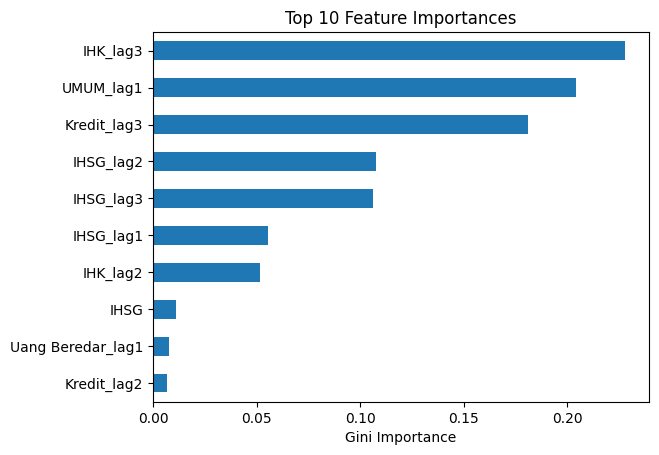

In [26]:
# Membuat plot visualisasi fitur-fitur paling berpengaruh 
pd.Series(
    random_forest_model.feature_importances_,
    index=X_train_scaled.columns
    ).sort_values().tail(10).plot.barh(title="Top 10 Feature Importances", xlabel='Gini Importance');

plt.show()

## Prophet Regressor with Holiday

**Facebook** developed Prophet, an open-source tool that leverages GAM to make time series forecasting more accessible to non-experts. Prophet builds upon the traditional trend and seasonality components and adds a holiday effect to model irregular schedules, such as holidays. 

**Prophet**'s straightforward approach allows users to input their data and generate forecasts with minimal coding knowledge. It also includes robust model diagnostics and visualization tools, making it easy to identify issues and adjust the model as necessary.

**Prophet** has been proven to be useful in various industries, including retail, finance, and transportation. The tool's ability to model the irregular schedules of holidays and other events has made it a popular choice for businesses that rely on accurate forecasting to make decisions. Additionally, Prophet's flexibility and ease of use make it an attractive option for businesses of all sizes, from small startups to large corporations.

In conclusion, Prophet is an innovative tool that leverages GAM to make time series forecasting more accessible and user-friendly. Its ability to model trend, seasonality, and holiday effects has made it a popular choice among businesses that require accurate forecasting to make informed decisions.

### Data Preparation

Prophet has rules to follow, one of the rules are the column names should be change to `ds` (for datetime column) and `y` (for value). Other name of columns will be assigned as regressor for time series forecasting.

In [96]:
df_prophet = clean_df.rename(columns={
    'Bulan': 'ds', 
    'UMUM': 'y',
    'Kurs RP USD': 'kurs_usd',
    'IHSG': 'ihsg',
    'Uang Beredar': 'uang_beredar',
    'Suku Bunga': 'suku_bunga',
    'Kredit': 'kredit',
    'IHK': 'ihk'
})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

df_prophet.head()

,ds,kurs_usd,ihsg,uang_beredar,y,ihk,suku_bunga,kredit
0,2019-01-01,14460.000000,6532.969238,5644985.0,2.479900,132.37,6.0,11.72
1,2019-02-01,13931.599609,6443.348145,5670778.0,2.671993,132.26,6.0,11.68
2,2019-03-01,14195.500000,6468.754883,5747247.0,2.372576,132.60,6.0,11.64
3,2019-04-01,14233.000000,6455.352051,5746732.0,2.610878,133.21,6.0,11.62
4,2019-05-01,14286.000000,6209.117188,5860509.0,3.118789,133.77,6.0,11.57


### Cross-Validation

Let's split the dataset into train and test dataset, where 20% of the last data will be assign as test dataset and others will be use for model training.

In [97]:
train_size = int(len(df_prophet) * 0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]

### Shock Event (Covid)

To prevent large dips and spikes from being captured by the trend component, we can treat the days impacted by COVID-19 as holidays that will not repeat again in the future. This kind of features is called shock event<sup>[[4]](#reference)</sup>.

In [98]:
lockdowns = pd.DataFrame([
    {'holiday': 'covid', 'ds': '2022-04-01', 'lower_window': 0, 'ds_upper': '2023-03-01'}
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,covid,2022-04-01,0,2023-03-01,334


### Modelling

In [99]:
best_params = {'changepoint_prior_scale': 0.001,
               'seasonality_prior_scale': np.float64(0.5),
               'yearly_seasonality': 10}

prophet_model = Prophet(**best_params,
                        holidays= lockdowns)


# Menambahkan regresor eksternal
prophet_model.add_regressor('kurs_usd')
prophet_model.add_regressor('ihsg')
prophet_model.add_regressor('uang_beredar')
prophet_model.add_regressor('ihk')
prophet_model.add_regressor('suku_bunga')
prophet_model.add_regressor('kredit');

prophet_model.fit(train);

15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:23 - cmdstanpy - INFO - Chain [1] done processing


### Predict

In [100]:
future_best = prophet_model.make_future_dataframe(periods=len(test), freq='M')
future_best['kurs_usd'] = df_prophet['kurs_usd'].tail(len(future_best)).values
future_best['ihsg'] = df_prophet['ihsg'].tail(len(future_best)).values
future_best['uang_beredar'] = df_prophet['uang_beredar'].tail(len(future_best)).values
future_best['ihk'] = df_prophet['ihk'].tail(len(future_best)).values
future_best['suku_bunga'] = df_prophet['suku_bunga'].tail(len(future_best)).values
future_best['kredit'] = df_prophet['kredit'].tail(len(future_best)).values

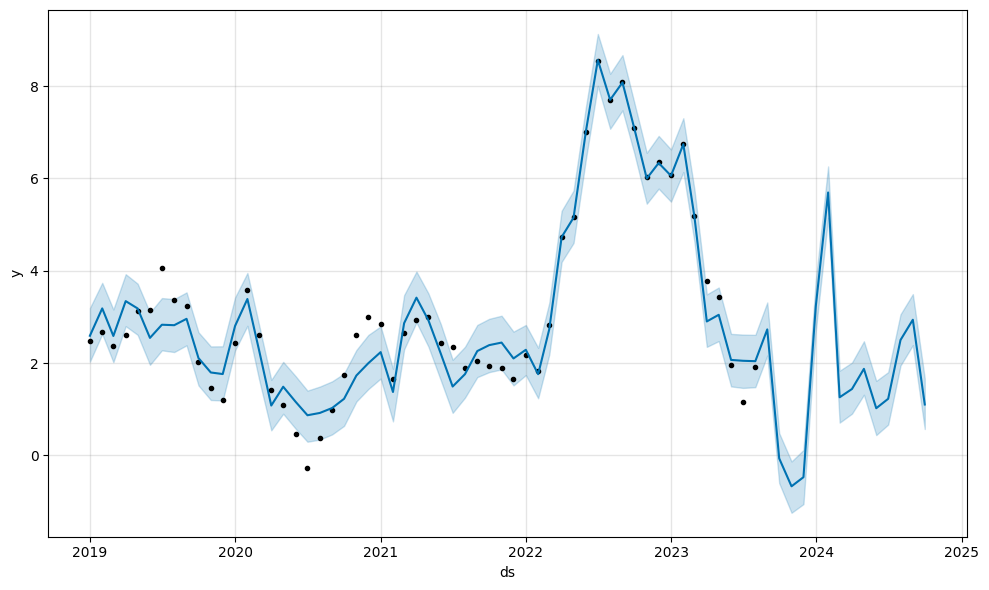

In [101]:
forecast_best = prophet_model.predict(future_best)

forecast_test = forecast_best['yhat'].tail(len(test)).values
y_actual = test['y'].values

# visualize
fig = prophet_model.plot(forecast_best)

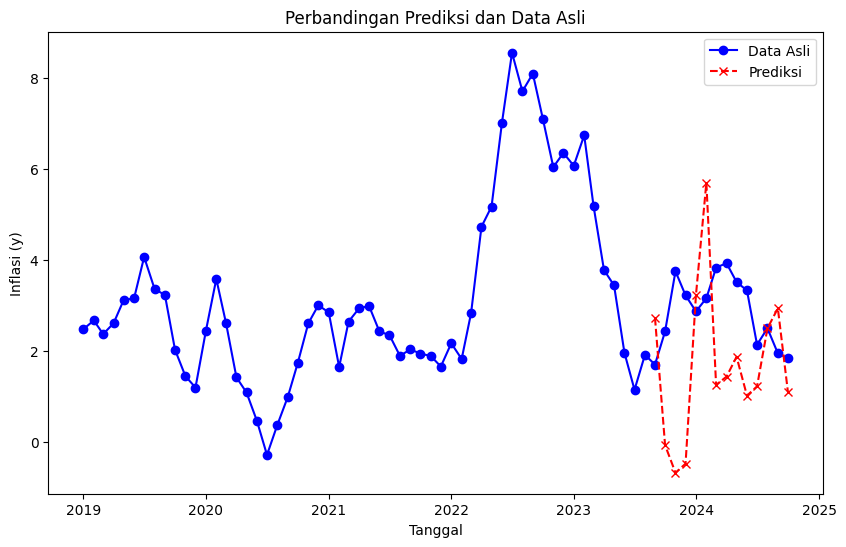

In [102]:
# Visualisasi perbandingan prediksi dengan data asli
plt.figure(figsize=(10, 6))
plt.plot(forecast_best['ds'], df_prophet['y'], label='Data Asli', color='blue', marker='o')
plt.plot(forecast_best['ds'].tail(len(test)), forecast_test, label='Prediksi', color='red', linestyle='--', marker='x')
plt.xlabel('Tanggal')
plt.ylabel('Inflasi (y)')  
plt.title('Perbandingan Prediksi dan Data Asli')
plt.legend()
plt.show()

### Evaluation

In [103]:
rmse_prophet = root_mean_squared_error(y_true=y_actual, y_pred=forecast_test)
mse_prophet = mean_squared_error(y_true=y_actual, y_pred=forecast_test)
mae_prophet = mean_absolute_error(y_true=y_actual, y_pred=forecast_test)
mape_prophet = mean_absolute_percentage_error(y_true=y_actual, y_pred=forecast_test)
list_eval_prophet = [rmse_prophet, mse_prophet, mae_prophet, mape_prophet]
print(f"RMSE Prophet: {rmse_prophet}")
print(f"MSE Prophet: {mse_prophet}")
print('MAE Prophet:', mae_prophet)
print(f'MAPE Prophet:{round((mape_prophet*100),2)}%')

RMSE Prophet: 2.240831144604761
MSE Prophet: 5.021324218630684
MAE Prophet: 1.8713675981779299
MAPE Prophet:62.04%


## Vanilla Neural Network

Next model will use neural network with 2 hidden layers. Adding layer resulted to overfit performance. This combination of layers and neurons is the best model that have tried for this data.

In [107]:
random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

input_columns = X_train_scaled.shape[1]

nn_model = keras.Sequential()
nn_model.add(keras.layers.InputLayer(input_shape=(input_columns,)))
nn_model.add(keras.layers.Dense(units=16, activation='relu'))
nn_model.add(keras.layers.Dense(units=32, activation='relu'))
nn_model.add(keras.layers.Dense(units=1, activation='relu'))

nn_model.compile(optimizer='adam', loss='mean_squared_error')

nn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,073 (4.19 KB)

 Trainable params: 1,073 (4.19 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
nn_model.fit(X_train_scaled, y_train, 
             validation_data=(X_test_scaled, y_test),
             epochs=10);

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 11.4306 - val_loss: 3.8712
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 10.8155 - val_loss: 3.3218
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 10.2167 - val_loss: 2.7836
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 9.6333 - val_loss: 2.2842
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 9.0680 - val_loss: 1.8448
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 8.5095 - val_loss: 1.4459
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 7.9641 - val_loss: 1.0948
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 7.4389 - val_loss: 0.8314
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 6.9338 - val_loss: 0.6839
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 6.4538 - val_loss: 0.6735


In [109]:
y_pred = np.squeeze(nn_model.predict(X_test_scaled))

rmse_nn = root_mean_squared_error(y_test, y_pred)
mse_nn = mean_squared_error(y_test, y_pred)
mae_nn = mean_absolute_error(y_test, y_pred)
mape_nn = mean_absolute_percentage_error(y_test, y_pred)
list_eval_nn = [rmse_nn, mse_nn, mae_nn, mape_nn]
print(f"RMSE Neural Network: {rmse_nn}")
print(f"MSE Neural Network: {mse_nn}")
print('MAE Neural Network:', mae_nn)
print(f'MAPE Neural Network:{round((mape_nn*100),2)}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
RMSE Neural Network: 0.8206774962574812
MSE Neural Network: 0.6735115528634481
MAE Neural Network: 0.672441915681001
MAPE Neural Network:26.07%


# Model Performance Summary

This table below compares all model performance in RMSE, MSE, MAE and MAPE metrics.

In [ ]:
eval_summary = pd.DataFrame(data = {"Random Forest": list_eval_rf,
                     "Prophet": list_eval_prophet,
                     'Neural Network': list_eval_nn},
             index = ["RMSE", 'MSE', 'MAE', 'MAPE']).T
# Ubah MAPE menjadi persentase
eval_summary['MAPE'] = (eval_summary['MAPE'] * 100).round(2).astype(str) + '%'

eval_summary.round(3).sort_values('RMSE')

,RMSE,MSE,MAE,MAPE
Neural Network,0.821,0.674,0.672,26.07%
Random Forest,1.356,1.838,1.224,51.24%
Prophet,2.241,5.021,1.871,62.04%


Neural network model with 2 hidden layers is the best model in every metrics among Random Forest and Prophet.

<a id="reference"></a>
# Reference

[1] [Machine Learning Methods for Inflation Forecasting in Brazil:
new contenders versus classical models](https://www.bcb.gov.br/pec/wps/ingl/wps561.pdf)

[2] [Inflation forecasting with Random Forest, Lund University](https://bulletin.bmeb-bi.org/cgi/viewcontent.cgi?article=1275&context=bmeb)

[3] [Putri, Nabila Aprilia (2024) Prediksi Tingkat Inflasi Kota Surabaya Berdasarkan Hasil Prediksi Harga Bahan Pokok Menggunakan Metode Long Short-Term Memory (LSTM). Other thesis, Institut Teknologi Sepuluh Nopember.](http://repository.its.ac.id/id/eprint/109561)

[4] [Treating COVID-19 lockdowns as a one-off holidays, Prophet official documentations](https://facebook.github.io/prophet/docs/handling_shocks.html#treating-covid-19-lockdowns-as-a-one-off-holidays)